In [5]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import json
import sys
import os

In [2]:
proj_dir = Path('../../')

geopackage_fn = proj_dir / 'data/gis/geopackages/columbia_river_basin.gpkg'
# landsat_data_fn = proj_dir / 'Data/landsat/columbia_clean.csv'
landsat_data_fn = proj_dir / 'Data/landsat/crb_landsat.csv'
insitu_data_dir = proj_dir / 'Data/insitu/conditions/processed'


In [3]:
# check the layers in the geopackage
import fiona
layers = fiona.listlayers(geopackage_fn)
print(layers)

['Basins', 'Dams', 'Reservoirs', 'fish_stations', 'FilteredReaches', 'Rivers', 'Stations', 'TempLocationsInBuffer', 'good2_dams', 'Reaches', 'BufferedReaches', 'GOOD2_dams_with_RKm']


In [6]:
sys.path.insert(0, os.path.abspath(proj_dir / "src"))

import thorr
from thorr.utils import config as cfg
from thorr.utils import database
from thorr.utils import logger

In [7]:
config = cfg.read_config(config_path=str(proj_dir / ".env/config/thorr_config.ini"), required_sections=['mysql'])
db_config_path = config['mysql']["db_config_path"]

db = database.Connect(str(proj_dir / db_config_path))
connection = db.connection
cursor = connection.cursor()

Connecting to MySQL database...
MySQL connection established.


In [8]:
buffered_reaches = gpd.read_file(geopackage_fn, layer='BufferedReaches')
stations = gpd.read_file(geopackage_fn, layer='Stations')
basin = gpd.read_file(geopackage_fn, layer='Basins')

<Axes: >

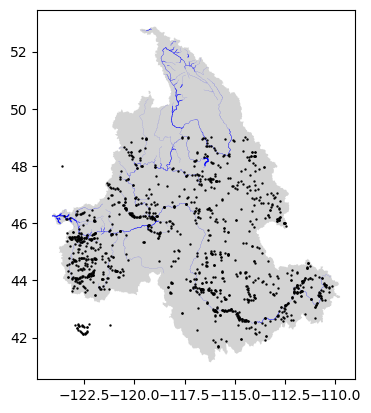

In [9]:
fig, ax = plt.subplots()
basin.plot(ax=ax, color='lightgray')
buffered_reaches.plot(ax=ax, color='blue')
stations.plot(ax=ax, color='black', markersize=0.5)

In [11]:
# use lambda to filter stations with fish data
temp_locations = stations[stations['available_data'].apply(lambda x: 'conditions' in json.loads(x))]
temp_locations = temp_locations[temp_locations['available_data'].apply(lambda x: 'avg_temp(C)' in json.loads(x)['conditions'])]
# find the temp locations in the basin
# temp_locations = temp_locations[temp_locations.within(basin.geometry.iloc[0])].copy()

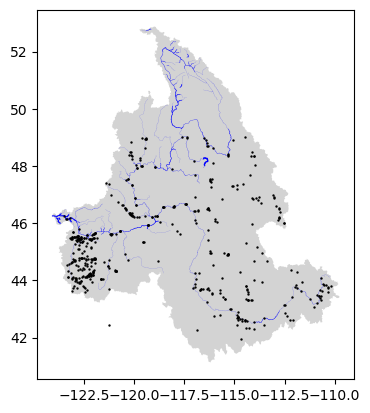

In [12]:
# plot temperature locations
fig, ax = plt.subplots()
basin.plot(ax=ax, color='lightgray')
buffered_reaches.plot(ax=ax, color='blue')
temp_locations.plot(ax=ax, color='black', markersize=0.5);

In [13]:
temp_locs_in_buffer = temp_locations[temp_locations.within(buffered_reaches.unary_union)].copy()
# temp_locs_in_buffer = gpd.read_file(geopackage_fn, layer='TempLocationsInBuffer')
temp_locs_in_buffer

,station_ID,id_at_source,available_data,source_URL,latitude,longitude,description,site_params,geometry
0,DART_ALF,ALF,"{""conditions"": [""outflow(m3/d)"", ""inflow(m3/d)...","{""url"": [""https://www.cbr.washington.edu/dart/...",48.178294,-116.997745,Albeni Falls Forebay and Dam,{},POINT (-116.99774 48.17829)
1,DART_BON,BON,"{""conditions"": [""outflow(m3/d)"", ""inflow(m3/d)...","{""url"": [""https://www.cbr.washington.edu/dart/...",45.644167,-121.940556,Bonneville Forebay and Dam,{},POINT (-121.94056 45.64417)
2,DART_CCIW,CCIW,"{""conditions"": [""outflow(m3/d)"", ""inflow(m3/d)...","{""url"": [""https://www.cbr.washington.edu/dart/...",45.648503,-121.940663,Cascade Island (below BON),{},POINT (-121.94066 45.64850)
3,DART_CHJ,CHJ,"{""conditions"": [""outflow(m3/d)"", ""inflow(m3/d)...","{""url"": [""https://www.cbr.washington.edu/dart/...",47.995278,-119.633333,Chief Joseph Forebay and Dam,{},POINT (-119.63333 47.99528)
4,DART_CHQW,CHQW,"{""conditions"": [""outflow(m3/d)"", ""inflow(m3/d)...","{""url"": [""https://www.cbr.washington.edu/dart/...",47.995278,-119.633333,Chief Joseph Tailrace,{},POINT (-119.63333 47.99528)
...,...,...,...,...,...,...,...,...,...
857,USGS_14128910,14128910,"{""conditions"": [""max_temp(C)"", ""min_temp(C)"", ...","{""url"": [""https://waterdata.usgs.gov/monitorin...",45.612340,-122.027584,"COLUMBIA RIVER AT WARRENDALE, OR",{},POINT (-122.02758 45.61234)
869,USGS_14171750,14171750,"{""conditions"": [""max_temp(C)"", ""min_temp(C)"", ...","{""url"": [""https://waterdata.usgs.gov/monitorin...",44.641511,-123.117873,"WILLAMETTE R AB CALAPOOIA R AT ALBANY,OREG.",{},POINT (-123.11787 44.64151)
878,USGS_14191000,14191000,"{""conditions"": [""max_temp(C)"", ""min_temp(C)"", ...","{""url"": [""https://waterdata.usgs.gov/monitorin...",44.944286,-123.042874,"WILLAMETTE RIVER AT SALEM, OR",{},POINT (-123.04287 44.94429)
903,USGS_453606121101000,453606121101000,"{""conditions"": [""max_temp(C)"", ""min_temp(C)"", ...","{""url"": [""https://waterdata.usgs.gov/monitorin...",45.601509,-121.170626,"COLUMBIA RIVER, LEFT BANK, NEAR THE DALLES, OR",{},POINT (-121.17063 45.60151)


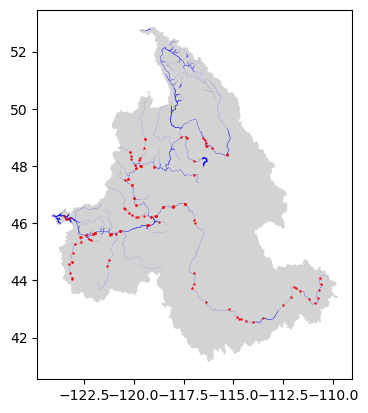

In [14]:
# filter temperature locations within the buffered
fig, ax = plt.subplots()
basin.plot(ax=ax, color='lightgray')
buffered_reaches.plot(ax=ax, color='blue')
temp_locs_in_buffer.plot(ax=ax, color='red', markersize=0.5);

In [15]:
buffered_reaches.columns

Index(['GNIS_Name', 'reach_id', 'RKm', 'OBJECTID', 'ID', 'WidthMin',
       'width_med_', 'WidthMean', 'WidthMax', 'width_sd_m', 'lakeFlag',
       'nSegPx', 'Shape_Leng', 'distance', 'DistToUpDam', 'DistToDownDam',
       'UpDamGrandID', 'DownDamGrandID', 'koppen', 'geometry'],
      dtype='object')

In [16]:
buffered_reaches.drop(columns=[col for col in buffered_reaches.columns if col in ['index_right', 'index_left']], inplace=True)
temp_locs_in_buffer.drop(columns=[col for col in temp_locs_in_buffer.columns if col in ['index_right', 'index_left']], inplace=True)

temp_locs_in_buffer = temp_locs_in_buffer.sjoin(buffered_reaches, how='left', predicate='within')
temp_locs_in_buffer.reset_index(drop=True, inplace=True)
temp_locs_in_buffer

,station_ID,id_at_source,available_data,source_URL,latitude,longitude,description,site_params,geometry,index_right,...,width_sd_m,lakeFlag,nSegPx,Shape_Leng,distance,DistToUpDam,DistToDownDam,UpDamGrandID,DownDamGrandID,koppen
0,DART_ALF,ALF,"{""conditions"": [""outflow(m3/d)"", ""inflow(m3/d)...","{""url"": [""https://www.cbr.washington.edu/dart/...",48.178294,-116.997745,Albeni Falls Forebay and Dam,{},POINT (-116.99774 48.17829),674,...,401.215525,0.0,5770.0,2.091935,0.00000,4.173191,86.463405,305.0,NaN,18
1,DART_BON,BON,"{""conditions"": [""outflow(m3/d)"", ""inflow(m3/d)...","{""url"": [""https://www.cbr.washington.edu/dart/...",45.644167,-121.940556,Bonneville Forebay and Dam,{},POINT (-121.94056 45.64417),154,...,390.232269,0.0,5787.0,2.213653,0.00000,9.970467,NaN,NaN,NaN,9
2,DART_BON,BON,"{""conditions"": [""outflow(m3/d)"", ""inflow(m3/d)...","{""url"": [""https://www.cbr.washington.edu/dart/...",45.644167,-121.940556,Bonneville Forebay and Dam,{},POINT (-121.94056 45.64417),155,...,390.232269,0.0,5787.0,2.213653,0.00000,0.430959,0.029530,NaN,NaN,9
3,DART_CCIW,CCIW,"{""conditions"": [""outflow(m3/d)"", ""inflow(m3/d)...","{""url"": [""https://www.cbr.washington.edu/dart/...",45.648503,-121.940663,Cascade Island (below BON),{},POINT (-121.94066 45.64850),154,...,390.232269,0.0,5787.0,2.213653,0.00000,9.970467,NaN,NaN,NaN,9
4,DART_CCIW,CCIW,"{""conditions"": [""outflow(m3/d)"", ""inflow(m3/d)...","{""url"": [""https://www.cbr.washington.edu/dart/...",45.648503,-121.940663,Cascade Island (below BON),{},POINT (-121.94066 45.64850),155,...,390.232269,0.0,5787.0,2.213653,0.00000,0.430959,0.029530,NaN,NaN,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,USGS_14128910,14128910,"{""conditions"": [""max_temp(C)"", ""min_temp(C)"", ...","{""url"": [""https://waterdata.usgs.gov/monitorin...",45.612340,-122.027584,"COLUMBIA RIVER AT WARRENDALE, OR",{},POINT (-122.02758 45.61234),154,...,390.232269,0.0,5787.0,2.213653,0.00000,9.970467,NaN,NaN,NaN,9
142,USGS_14171750,14171750,"{""conditions"": [""max_temp(C)"", ""min_temp(C)"", ...","{""url"": [""https://waterdata.usgs.gov/monitorin...",44.641511,-123.117873,"WILLAMETTE R AB CALAPOOIA R AT ALBANY,OREG.",{},POINT (-123.11787 44.64151),996,...,26.332810,0.0,3247.0,1.129265,0.00000,NaN,NaN,NaN,NaN,9
143,USGS_14191000,14191000,"{""conditions"": [""max_temp(C)"", ""min_temp(C)"", ...","{""url"": [""https://waterdata.usgs.gov/monitorin...",44.944286,-123.042874,"WILLAMETTE RIVER AT SALEM, OR",{},POINT (-123.04287 44.94429),989,...,123.435431,0.0,6227.0,2.197430,0.00000,NaN,NaN,NaN,NaN,9
144,USGS_453606121101000,453606121101000,"{""conditions"": [""max_temp(C)"", ""min_temp(C)"", ...","{""url"": [""https://waterdata.usgs.gov/monitorin...",45.601509,-121.170626,"COLUMBIA RIVER, LEFT BANK, NEAR THE DALLES, OR",{},POINT (-121.17063 45.60151),163,...,390.232269,0.0,5787.0,2.213653,0.00000,5.087651,69.569042,NaN,NaN,8


In [17]:
# # show duplicates in temp_locs_in_buffer
# temp_locs_in_buffer[temp_locs_in_buffer.duplicated(subset='station_ID', keep=False)][['station_ID', 'RKm']]

# drop duplicates
# temp_locs_in_buffer.drop_duplicates(subset='station_ID', inplace=True)

In [18]:
# # retrieve the landsat data from from the MySQL database
# query = """
# SELECT 
#     ReachID, Date, LandTempC, WaterTempC, NDVI, Mission, Name, ClimateClass, RKm, WidthMin, WidthMean, WidthMax
# FROM
#     thorr_dev.ReachLandsatData
#         LEFT JOIN
#     thorr_dev.Reaches USING (ReachID)
# ORDER BY Name;
# """

# df = conn.query_with_fetchmany(query, chunksize=100)

# df.to_csv(landsat_data_fn, index=False)

In [19]:
df = None
lsat_data = pd.read_csv(landsat_data_fn, parse_dates=['Date'])

In [20]:
lsat_data

,ReachID,Date,LandTempC,WaterTempC,NDVI,Mission,Name,ClimateClass,RKm,WidthMin,WidthMean,WidthMax
0,1,2011-08-17,7.904020,NaN,0.583102,L5,Akolkolex_River_1,27,0,30.0,850.0,5603.0
1,1,2011-08-24,20.048400,13.840800,0.795046,L5,Akolkolex_River_1,27,0,30.0,850.0,5603.0
2,1,2011-09-09,19.918400,13.377900,0.759720,L5,Akolkolex_River_1,27,0,30.0,850.0,5603.0
3,1,2011-10-27,-0.910537,6.319240,0.072241,L5,Akolkolex_River_1,27,0,30.0,850.0,5603.0
4,1,2011-11-05,-4.847170,0.060847,0.271200,L5,Akolkolex_River_1,27,0,30.0,850.0,5603.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1276110,1060,2022-08-28,18.028200,NaN,0.912089,L9,Youngs_River_5,9,40,NaN,NaN,NaN
1276111,1060,2022-09-06,25.396200,NaN,0.919168,L9,Youngs_River_5,9,40,NaN,NaN,NaN
1276112,1060,2022-10-08,22.695800,NaN,0.901385,L9,Youngs_River_5,9,40,NaN,NaN,NaN
1276113,1060,2022-10-15,23.266100,NaN,0.896315,L9,Youngs_River_5,9,40,NaN,NaN,NaN


In [21]:
lsat_data.columns

Index(['ReachID', 'Date', 'LandTempC', 'WaterTempC', 'NDVI', 'Mission', 'Name',
       'ClimateClass', 'RKm', 'WidthMin', 'WidthMean', 'WidthMax'],
      dtype='object')

In [22]:
lsat_data['Date'] = pd.to_datetime(lsat_data['Date'])

In [23]:
temp_locs_in_buffer.columns

Index(['station_ID', 'id_at_source', 'available_data', 'source_URL',
       'latitude', 'longitude', 'description', 'site_params', 'geometry',
       'index_right', 'GNIS_Name', 'reach_id', 'RKm', 'OBJECTID', 'ID',
       'WidthMin', 'width_med_', 'WidthMean', 'WidthMax', 'width_sd_m',
       'lakeFlag', 'nSegPx', 'Shape_Leng', 'distance', 'DistToUpDam',
       'DistToDownDam', 'UpDamGrandID', 'DownDamGrandID', 'koppen'],
      dtype='object')

In [24]:
combined_insitu = pd.DataFrame()

for temp_loc in temp_locs_in_buffer.itertuples():
    insitu_fn = insitu_data_dir / f"{temp_loc.station_ID}.csv"
    if insitu_fn.exists():
        insitu_data = pd.read_csv(insitu_fn, parse_dates=['date'])
        # print(insitu_data.columns)
        # drop utc in date
        insitu_data['date'] = insitu_data['date'].dt.tz_localize(None)

        # keep date and average temperature
        # insitu_data = insitu_data[['date', 'avg_temp(C)', ]]
        # replace -999999 with nan
        # insitu_data.replace(-999999, np.nan, inplace=True)
        insitu_data.dropna(inplace=True)
        insitu_data['station_ID'] = temp_loc.station_ID
        insitu_data['RKm'] = temp_loc.RKm
        insitu_data['Name'] = temp_loc.reach_id
        combined_insitu = pd.concat([combined_insitu, insitu_data])
        # break

# combined_insitu = pd.concat(combined_insitu)

combined_insitu.rename(columns={'date': 'Date'}, inplace=True)
# combined_insitu = combined_insitu.merge(lsat_data, on='Date', how='left')
# Data/insitu/conditions/processed

In [25]:
combined_insitu

,Date,outflow(m3/d),inflow(m3/d),spill(m3/d),avg_temp(C),wse(m),station_ID,RKm,Name,wse_tail(m),max_temp(C),min_temp(C),avg discharge (cfs)
1945,2004-04-29,4.932288e+07,6.923797e+07,0.0,11.89,626.245128,DART_ALF,140,Pend_Oreille_River_15,NaN,NaN,NaN,NaN
1946,2004-04-30,4.991006e+07,6.654675e+07,0.0,11.84,626.318280,DART_ALF,140,Pend_Oreille_River_15,NaN,NaN,NaN,NaN
1947,2004-05-01,4.937181e+07,5.945169e+07,0.0,12.29,626.354856,DART_ALF,140,Pend_Oreille_River_15,NaN,NaN,NaN,NaN
1948,2004-05-02,4.856444e+07,6.067497e+07,0.0,12.26,626.364000,DART_ALF,140,Pend_Oreille_River_15,NaN,NaN,NaN,NaN
1949,2004-05-03,5.531698e+07,8.563000e+07,0.0,12.92,626.382288,DART_ALF,140,Pend_Oreille_River_15,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,1998-09-11,NaN,NaN,NaN,20.80,NaN,USGS_460923123235800,60,Columbia_River_7,NaN,20.9,20.7,NaN
485,1998-09-12,NaN,NaN,NaN,20.80,NaN,USGS_460923123235800,60,Columbia_River_7,NaN,20.9,20.6,NaN
486,1998-09-13,NaN,NaN,NaN,20.60,NaN,USGS_460923123235800,60,Columbia_River_7,NaN,20.7,20.4,NaN
487,1998-09-14,NaN,NaN,NaN,20.50,NaN,USGS_460923123235800,60,Columbia_River_7,NaN,20.6,20.4,NaN


<Axes: xlabel='outflow(m3/d)', ylabel='avg_temp(C)'>

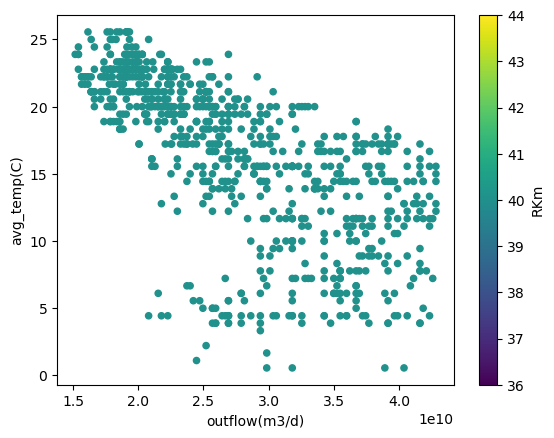

In [26]:
combined_insitu[(combined_insitu['avg_temp(C)']>0) & (combined_insitu['outflow(m3/d)']>1e10)].sort_values(by='outflow(m3/d)').plot('outflow(m3/d)', 'avg_temp(C)', kind='scatter', c='RKm', cmap='viridis')

## Compare Landsat Data with Insitu

In [27]:
combined_insitu

,Date,outflow(m3/d),inflow(m3/d),spill(m3/d),avg_temp(C),wse(m),station_ID,RKm,Name,wse_tail(m),max_temp(C),min_temp(C),avg discharge (cfs)
1945,2004-04-29,4.932288e+07,6.923797e+07,0.0,11.89,626.245128,DART_ALF,140,Pend_Oreille_River_15,NaN,NaN,NaN,NaN
1946,2004-04-30,4.991006e+07,6.654675e+07,0.0,11.84,626.318280,DART_ALF,140,Pend_Oreille_River_15,NaN,NaN,NaN,NaN
1947,2004-05-01,4.937181e+07,5.945169e+07,0.0,12.29,626.354856,DART_ALF,140,Pend_Oreille_River_15,NaN,NaN,NaN,NaN
1948,2004-05-02,4.856444e+07,6.067497e+07,0.0,12.26,626.364000,DART_ALF,140,Pend_Oreille_River_15,NaN,NaN,NaN,NaN
1949,2004-05-03,5.531698e+07,8.563000e+07,0.0,12.92,626.382288,DART_ALF,140,Pend_Oreille_River_15,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,1998-09-11,NaN,NaN,NaN,20.80,NaN,USGS_460923123235800,60,Columbia_River_7,NaN,20.9,20.7,NaN
485,1998-09-12,NaN,NaN,NaN,20.80,NaN,USGS_460923123235800,60,Columbia_River_7,NaN,20.9,20.6,NaN
486,1998-09-13,NaN,NaN,NaN,20.60,NaN,USGS_460923123235800,60,Columbia_River_7,NaN,20.7,20.4,NaN
487,1998-09-14,NaN,NaN,NaN,20.50,NaN,USGS_460923123235800,60,Columbia_River_7,NaN,20.6,20.4,NaN


In [28]:
# lsat_data['Name']

In [29]:
insitu_lsat = pd.merge(combined_insitu, lsat_data, on=['Date', 'Name', 'RKm'], how='inner')
# insitu_lsat = insitu_lsat.resample('SMS', on='Date').mean(numeric_only=True)
insitu_lsat['error'] = insitu_lsat['WaterTempC'] - insitu_lsat['avg_temp(C)']
insitu_lsat['abs_error'] = insitu_lsat['error'].abs()
insitu_lsat['percent_error'] = (insitu_lsat['WaterTempC'] - insitu_lsat['avg_temp(C)']) / insitu_lsat['avg_temp(C)'] * 100
# insitu_lsat = insitu_lsat[(insitu_lsat['avg_temp(C)'] >=-10) & (insitu_lsat['WaterTempC'] >=-40) & (insitu_lsat['WaterTempC'] <= 80) & (insitu_lsat['avg_temp(C)'] <= 40)]

# insitu_lsat.columns

In [30]:
insitu_lsat['WaterTempC'].dropna()

0         3.30774
1         3.30774
2         4.96250
3         4.96250
4         7.36857
           ...   
72610    21.89440
72611    22.35800
72612    20.36390
72613    21.39350
72614    20.03210
Name: WaterTempC, Length: 67360, dtype: float64

In [31]:
# import seaborn as sns
# sns.pairplot(insitu_lsat[['error', 'WidthMax', 'WaterTempC', 'avg_temp(C)', 'abs_error']])

### All Landsat Missions

In [32]:
insitu_lsat_clean = insitu_lsat[(insitu_lsat['avg_temp(C)'] >=0) & (insitu_lsat['WaterTempC'] >=-40) & (insitu_lsat['WaterTempC'] <= 80) & (insitu_lsat['avg_temp(C)'] <= 40)].copy()

In [33]:
insitu_lsat_clean[['WidthMin', 'WidthMean', 'WidthMax']] = insitu_lsat_clean[['WidthMin', 'WidthMean', 'WidthMax']].fillna(15)

In [34]:
insitu_lsat_clean.sort_values(by='Date', ascending=True)

,Date,outflow(m3/d),inflow(m3/d),spill(m3/d),avg_temp(C),wse(m),station_ID,RKm,Name,wse_tail(m),...,WaterTempC,NDVI,Mission,ClimateClass,WidthMin,WidthMean,WidthMax,error,abs_error,percent_error
5327,1985-02-12,4.671239e+08,4.504138e+08,7.388646e+06,1.11,22.521672,DART_BON,220,Columbia_River_23,NaN,...,0.006958,0.087747,L5,9,30.0,1094.0,2273.0,-1.103042,1.103042,-99.373127
8996,1985-02-12,4.671239e+08,4.504138e+08,7.388646e+06,1.11,22.521672,DART_BON,230,Columbia_River_24,NaN,...,0.012408,0.196563,L5,9,30.0,1094.0,2273.0,-1.097592,1.097592,-98.882117
5328,1985-02-28,5.102570e+08,5.311507e+08,8.489603e+06,3.89,22.814280,DART_BON,220,Columbia_River_23,NaN,...,1.401820,0.310357,L5,9,30.0,1094.0,2273.0,-2.488180,2.488180,-63.963496
8997,1985-02-28,5.102570e+08,5.311507e+08,8.489603e+06,3.89,22.814280,DART_BON,230,Columbia_River_24,NaN,...,1.438580,0.408015,L5,9,30.0,1094.0,2273.0,-2.451420,2.451420,-63.018509
5329,1985-03-16,4.086998e+08,4.053969e+08,0.000000e+00,6.11,22.878288,DART_BON,220,Columbia_River_23,NaN,...,5.480790,0.307066,L5,9,30.0,1094.0,2273.0,-0.629210,0.629210,-10.298036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68472,2024-02-25,2.047780e+07,NaN,NaN,7.70,NaN,USGS_14103000,0,Deschutes_River_1,NaN,...,11.776800,0.385036,L9,8,30.0,50.0,753.0,4.076800,4.076800,52.945455
67511,2024-02-25,2.436785e+06,NaN,NaN,7.50,NaN,USGS_14076500,190,Deschutes_River_20,NaN,...,6.886630,0.262717,L9,7,30.0,432.0,1145.0,-0.613370,0.613370,-8.178267
72441,2024-02-25,NaN,NaN,NaN,5.30,NaN,USGS_454249120423500,340,Columbia_River_35,NaN,...,4.846320,0.329876,L9,8,500.0,965.0,1532.0,-0.453680,0.453680,-8.560000
55229,2024-02-25,5.994100e+05,NaN,NaN,5.10,NaN,USGS_12439500,120,Okanogan_River_13,NaN,...,11.087400,0.278932,L9,7,30.0,72.0,2575.0,5.987400,5.987400,117.400000


In [35]:
# bin insitu_lsat by average temperature
insitu_lsat_clean['avg_temp_bin'] = pd.cut(insitu_lsat_clean['avg_temp(C)'], bins=np.arange(0, 40, 2.5))

# calculate mean, min, max, 75, 25, and standard deviation of water temperature
insitu_lsat_agg = insitu_lsat_clean.groupby('avg_temp_bin').agg({'WaterTempC': ['mean', 'min', 'max', 'std', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75), lambda x: x.quantile(0.5)]})

insitu_lsat_agg.columns = ['mean', 'min', 'max', 'std', 'q25', 'q75', 'q50']

insitu_lsat_agg.reset_index(inplace=True)
insitu_lsat_agg['avg_temp(C)'] = insitu_lsat_agg['avg_temp_bin'].apply(lambda x: x.mid)

insitu_lsat_agg['iqr'] = insitu_lsat_agg['q75'] - insitu_lsat_agg['q25']
insitu_lsat_agg


,avg_temp_bin,mean,min,max,std,q25,q75,q50,avg_temp(C),iqr
0,"(0.0, 2.5]",-1.822708,-30.58770,19.5793,5.382980,-3.633633,0.991817,-0.889363,1.25,4.625450
1,"(2.5, 5.0]",3.029509,-32.07880,57.4596,3.329570,1.614248,4.567353,3.208830,3.75,2.953105
2,"(5.0, 7.5]",6.381989,-28.70180,59.6509,4.100085,4.452150,8.097540,6.312410,6.25,3.645390
3,"(7.5, 10.0]",9.696353,-39.95730,28.0466,3.825759,7.596130,11.593200,9.594730,8.75,3.997070
4,"(10.0, 12.5]",12.993021,-6.65214,30.9700,3.876961,10.783800,15.063500,12.895200,11.25,4.279700
5,"(12.5, 15.0]",16.065900,-9.90610,36.2303,4.288373,13.539100,18.193200,15.730700,13.75,4.654100
6,"(15.0, 17.5]",18.580552,-2.96666,44.3943,3.915830,16.355000,20.685200,18.341950,16.25,4.330200
7,"(17.5, 20.0]",20.954259,-2.96666,44.3943,3.437246,19.202000,22.553000,20.670300,18.75,3.351000
8,"(20.0, 22.5]",23.134087,1.91553,42.6622,3.207770,21.427500,24.591400,22.813800,21.25,3.163900
9,"(22.5, 25.0]",26.475839,-0.09001,54.3561,4.056030,23.896100,28.627800,25.692600,23.75,4.731700


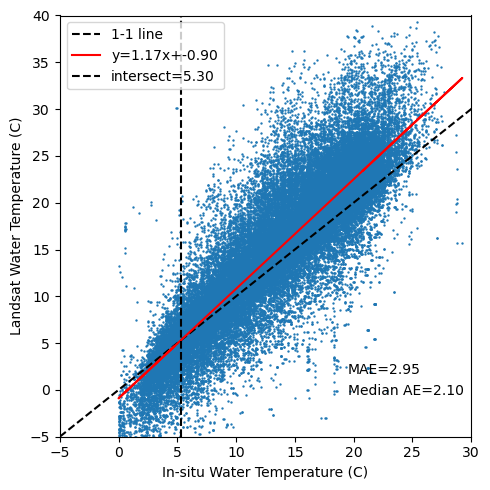

In [36]:
# generate line of best fit
# m, b = np.polyfit(insitu_lsat_clean['WaterTempC'], insitu_lsat_clean['avg_temp(C)'], 1)
m, b = np.polyfit(insitu_lsat_clean["avg_temp(C)"], insitu_lsat_clean["WaterTempC"], 1)

intersect = b / (1 - m)

# fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))
fig, (ax0) = plt.subplots(1, 1, figsize=(5, 5) )

insitu_lsat_clean.plot.scatter(y="WaterTempC", x="avg_temp(C)", ax=ax0, s=0.5)
# insitu_lsat_clean.plot.scatter(
#     y="WaterTempC", x="avg_temp(C)", ax=ax1, s=0.5, c="ClimateClass", cmap="viridis"
# )
# insitu_lsat_clean.plot.scatter(
#     y="WaterTempC", x="avg_temp(C)", ax=ax2, s=0.5, c="WidthMax", cmap="viridis"
# )

# draw 1-1 line
ax0.plot([-5, 40], [-5, 40], color="black", linestyle="--", label="1-1 line")
ax0.plot(
    insitu_lsat_clean["avg_temp(C)"],
    m * insitu_lsat_clean["avg_temp(C)"] + b,
    color="red",
    label=f"y={m:.2f}x+{b:.2f}",
)

# annotate with MAE and RMSE
ax0.annotate(
    f"MAE={insitu_lsat_clean['abs_error'].mean():.2f}",
    xy=(0.70, 0.15),
    xycoords="axes fraction",
)
ax0.annotate(
    f"Median AE={insitu_lsat_clean['abs_error'].median():.2f}",
    xy=(0.70, 0.10),
    xycoords="axes fraction",
)
# ax0.annotate(
#     f"RMSE={np.sqrt((insitu_lsat_clean['error'] ** 2).mean()):.2f}",
#     xy=(0.70, 0.05),
#     xycoords="axes fraction",
# )

# ax0.plot(
#     [intersect, intersect],
#     [-5, 40],
#     color="green",
#     linestyle="--",
#     label=f"intersect={intersect:.2f}",
# )

ax0.axvline(x=intersect, color="black", linestyle="--", label=f"intersect={intersect:.2f}")


ax0.set_ylabel("Landsat Water Temperature (C)")
ax0.set_xlabel("In-situ Water Temperature (C)")
ax0.set_xlim(-5, 30)
ax0.set_ylim(-5, 40)

# # plot the error bars
# ax0.errorbar(
#     insitu_lsat_agg["avg_temp(C)"],
#     insitu_lsat_agg["mean"],
#     yerr=insitu_lsat_agg["std"],
#     fmt="o",
#     color="black",
#     label="std",
# )


# # draw 1-1 line
# ax1.plot([-5, 40], [-5, 40], color="black", linestyle="--", label="1-1 line")
# ax1.plot(
#     insitu_lsat_clean["avg_temp(C)"],
#     m * insitu_lsat_clean["avg_temp(C)"] + b,
#     color="red",
#     label=f"y={m:.2f}x+{b:.2f}",
# )

# # ax1.plot([intersect, intersect], [-5, 40], color='green', linestyle='--', label=f'intersect={intersect:.2f}')


# ax1.set_ylabel("Landsat Water Temperature (C)")
# ax1.set_xlabel("In-situ Water Temperature (C)")
# ax1.set_xlim(0, 30)
# ax1.set_ylim(-30, 60)

# # draw 1-1 line
# ax2.plot([-5, 40], [-5, 40], color="black", linestyle="--", label="1-1 line")
# ax2.plot(
#     insitu_lsat_clean["avg_temp(C)"],
#     m * insitu_lsat_clean["avg_temp(C)"] + b,
#     color="red",
#     label=f"y={m:.2f}x+{b:.2f}",
# )

# # ax1.plot([intersect, intersect], [-5, 40], color='green', linestyle='--', label=f'intersect={intersect:.2f}')

# ax2.set_ylabel("Landsat Water Temperature (C)")
# ax2.set_xlabel("In-situ Water Temperature (C)")
# ax2.set_xlim(-5, 30)
# ax2.set_ylim(-30, 60)

# ax1.set_title('In-situ vs Landsat Water Temperature (All Landsat Missions)')

ax0.legend(loc="upper left")
# ax1.legend(loc="upper left")
# ax2.legend(loc="upper left")

fig.tight_layout();

In [37]:
# # plot pair plot
# import seaborn as sns

# sns.pairplot(insitu_lsat_clean)





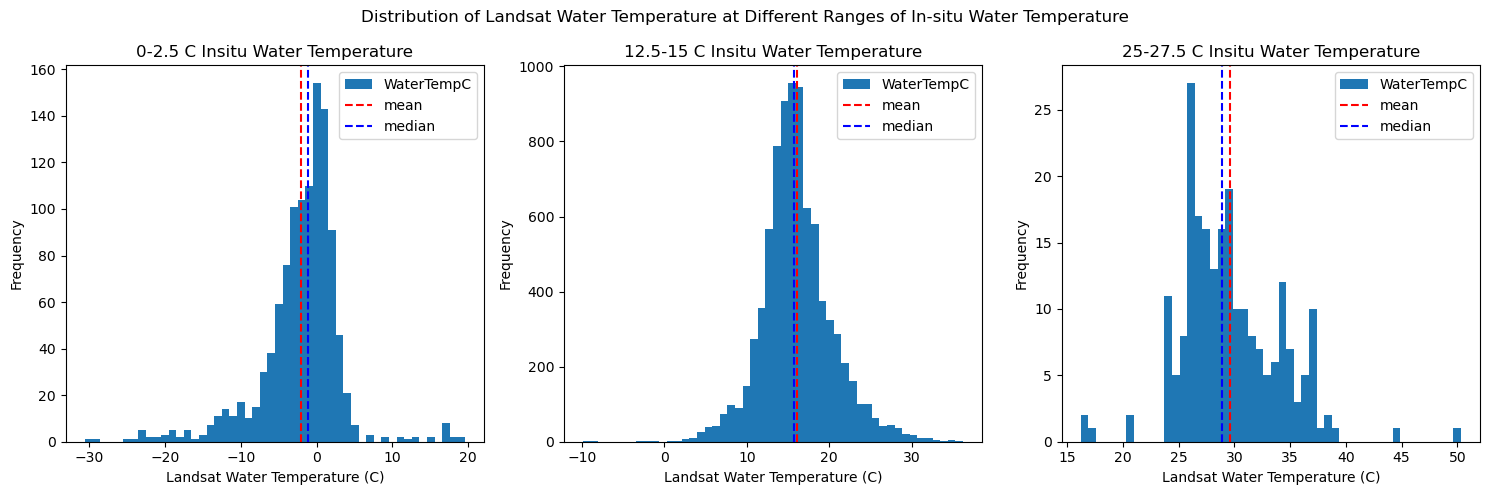

In [38]:
# See the distribution of water temperature at different average temperature (at the extremes)

# select data with average temperature between 0 and 2.5
insitu_lsat_clean_0_2_5 = insitu_lsat_clean[
    (insitu_lsat_clean["avg_temp(C)"] >= 0) & (insitu_lsat_clean["avg_temp(C)"] <= 2.5)
]
insitu_lsat_clean_25_27_5 = insitu_lsat_clean[
    (insitu_lsat_clean["avg_temp(C)"] >= 25)
    & (insitu_lsat_clean["avg_temp(C)"] <= 27.5)
]
insitu_lsat_clean_12_5_15 = insitu_lsat_clean[
    (insitu_lsat_clean["avg_temp(C)"] >= 12.5)
    & (insitu_lsat_clean["avg_temp(C)"] <= 15)
]

# plot distribution of water temperature
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))
insitu_lsat_clean_0_2_5["WaterTempC"].plot(kind="hist", bins=50, ax=ax0, title="0-2.5 C Insitu Water Temperature")
insitu_lsat_clean_12_5_15["WaterTempC"].plot(
    kind="hist", bins=50, ax=ax1, title="12.5-15 C Insitu Water Temperature"
)
insitu_lsat_clean_25_27_5["WaterTempC"].plot(
    kind="hist", bins=50, ax=ax2, title="25-27.5 C Insitu Water Temperature"
)

# plot mean and median lines
ax0.axvline(insitu_lsat_clean_0_2_5["WaterTempC"].mean(), color="red", linestyle="--", label="mean")
ax0.axvline(insitu_lsat_clean_0_2_5["WaterTempC"].median(), color="blue", linestyle="--", label="median")
ax1.axvline(insitu_lsat_clean_12_5_15["WaterTempC"].mean(), color="red", linestyle="--", label="mean")
ax1.axvline(insitu_lsat_clean_12_5_15["WaterTempC"].median(), color="blue", linestyle="--", label="median")
ax2.axvline(insitu_lsat_clean_25_27_5["WaterTempC"].mean(), color="red", linestyle="--", label="mean")
ax2.axvline(insitu_lsat_clean_25_27_5["WaterTempC"].median(), color="blue", linestyle="--", label="median")

ax0.set_xlabel("Landsat Water Temperature (C)")
ax1.set_xlabel("Landsat Water Temperature (C)")
ax2.set_xlabel("Landsat Water Temperature (C)")

ax0.legend()
ax1.legend()
ax2.legend()

fig.suptitle("Distribution of Landsat Water Temperature at Different Ranges of In-situ Water Temperature")
fig.tight_layout()

From the distribution plots above, there seems to be different distributions of errors at different temperature ranges.

The distribution for the low temperatures are negatively skewed. This means that when the actual water temperature shifts towards the cold extremes, the Landsat observations tend to underestimate more.
The reverse happens for the high range of temperatures. The distribution of landsat observations is positively skewed. There is more overestimation in the high water temperature range.
In the mid temperature range, the landsat observations are normally distributed.

In [39]:
rmse_0_2_5 = np.sqrt(np.mean(insitu_lsat_clean_0_2_5["error"] ** 2))
rmse_25_27_5 = np.sqrt(np.mean(insitu_lsat_clean_25_27_5["error"] ** 2))
rmse_12_5_15 = np.sqrt(np.mean(insitu_lsat_clean_12_5_15["error"] ** 2))

print(f"RMSE 0-2.5 C: {rmse_0_2_5:.2f} C")
print(f"RMSE 25-27.5 C: {rmse_25_27_5:.2f} C")
print(f"RMSE 12.5-15 C: {rmse_12_5_15:.2f} C")

RMSE 0-2.5 C: 6.24 C
RMSE 25-27.5 C: 5.78 C
RMSE 12.5-15 C: 4.80 C



Also, this means that the error decreases as the temperature increases

### Variation of error with in-situ temperature ranges

In [40]:
# bin insitu_lsat by average temperature
insitu_lsat_clean['avg_temp_bin'] = pd.cut(insitu_lsat_clean['avg_temp(C)'], bins=np.arange(-0, 40, 2.5))

# calculate mean, min, max, 75, 25, and standard deviation of water temperature
insitu_err_agg = insitu_lsat_clean.groupby('avg_temp_bin').agg({'error': ['mean', 'min', 'max', 'std', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75), lambda x: x.quantile(0.5), lambda x: np.sqrt(np.mean(x**2)),  lambda x: np.abs(x).mean()]})

insitu_err_agg.columns = ['mean', 'min', 'max', 'std', 'q25', 'q75', 'q50', 'rmse', 'mae']

insitu_err_agg.reset_index(inplace=True)
insitu_err_agg['avg_temp(C)'] = insitu_err_agg['avg_temp_bin'].apply(lambda x: x.mid)

insitu_err_agg['iqr'] = insitu_err_agg['q75'] - insitu_err_agg['q25']
insitu_err_agg


,avg_temp_bin,mean,min,max,std,q25,q75,q50,rmse,mae,avg_temp(C),iqr
0,"(0.0, 2.5]",-3.407538,-30.98770,18.3193,5.173477,-4.938568,-0.907490,-2.551945,6.192817,4.227962,1.25,4.031078
1,"(2.5, 5.0]",-0.867289,-36.37880,53.7496,3.192618,-2.133549,0.516657,-0.620990,3.308018,2.008733,3.75,2.650206
2,"(5.0, 7.5]",0.057215,-35.11180,54.3909,4.043801,-1.749710,1.720510,0.062060,4.043834,2.475580,6.25,3.470220
3,"(7.5, 10.0]",0.890901,-49.55730,19.0466,3.707515,-1.117835,2.712350,0.777600,3.812771,2.724095,8.75,3.830185
4,"(10.0, 12.5]",1.644985,-18.55214,19.7880,3.746003,-0.463000,3.594300,1.478050,4.091039,3.081555,11.25,4.057300
5,"(12.5, 15.0]",2.256396,-22.80610,21.9630,4.217122,-0.183800,4.359500,1.921400,4.782599,3.546233,13.75,4.543300
6,"(15.0, 17.5]",2.265276,-20.16666,27.0143,3.849534,0.053225,4.278225,1.954200,4.466397,3.333570,16.25,4.225000
7,"(17.5, 20.0]",2.129750,-20.57666,26.8843,3.353560,0.435000,3.570700,1.795000,3.972574,2.894408,18.75,3.135700
8,"(20.0, 22.5]",2.001147,-19.52447,22.2622,3.150363,0.373400,3.363400,1.616500,3.732076,2.671879,21.25,2.990000
9,"(22.5, 25.0]",3.060679,-22.93001,29.5561,3.973871,0.470700,5.165000,2.295000,5.014963,3.681654,23.75,4.694300


Text(0.5, 1.0, 'Boxplot of Error by Average Temperature')

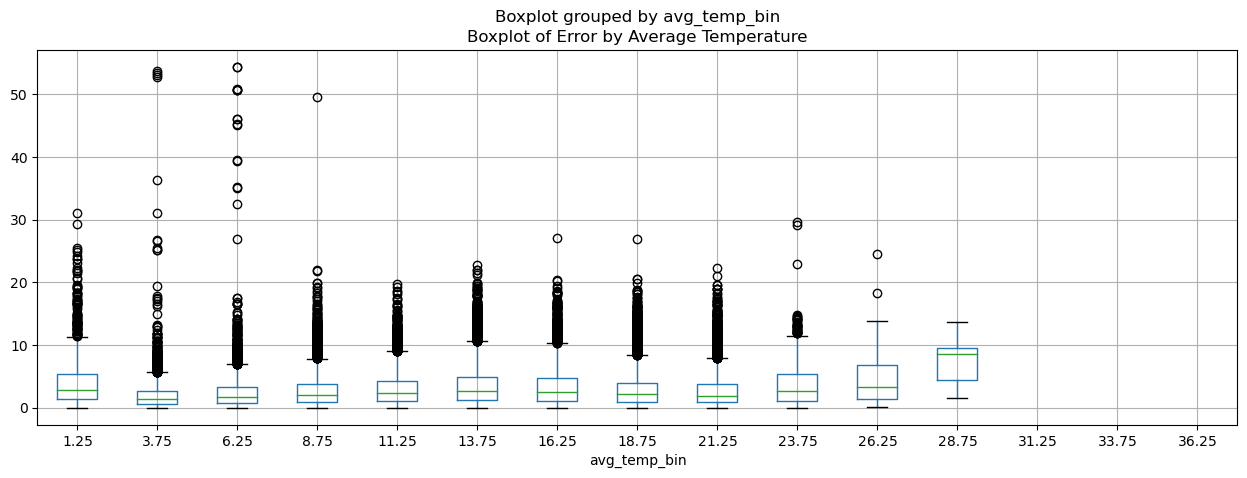

In [41]:
# boxplot of error
fig, ax = plt.subplots(figsize=(15, 5))
insitu_lsat_clean.boxplot('abs_error', by='avg_temp_bin', ax=ax)
# # plot mean and median lines
# ax.plot(insitu_err_agg['rmse'], color='red', linestyle='--', label='mean')
# set x tick labels to mid of bin
ax.set_xticklabels(insitu_err_agg['avg_temp(C)'])
ax.set_title('Boxplot of Error by Average Temperature')

Text(0.5, 1.0, 'RMSE by Average Temperature')

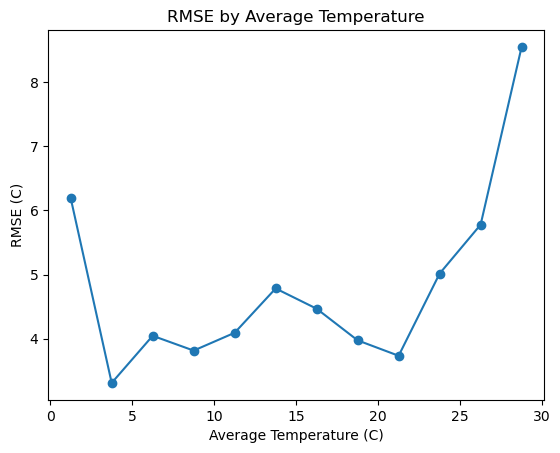

In [42]:
# plot the mean errors
fig, ax = plt.subplots()
ax.plot(insitu_err_agg['avg_temp(C)'], insitu_err_agg['rmse'], marker='o')
ax.set_ylabel('RMSE (C)')
ax.set_xlabel('Average Temperature (C)')
ax.set_title('RMSE by Average Temperature')

### Variation of error with mean width ranges

In [43]:
# bin insitu_lsat by average temperature
insitu_lsat_clean['width_mean_bin'] = pd.cut(insitu_lsat_clean['WidthMean'], bins=np.arange(0, 5000, 120))

# calculate mean, min, max, 75, 25, and standard deviation of water temperature
width_err_agg = insitu_lsat_clean.groupby('width_mean_bin').agg({'abs_error': ['mean', 'min', 'max', 'std', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75), lambda x: x.quantile(0.5), lambda x: np.sqrt(np.mean(x**2)), lambda x: np.abs(x).mean()]})

width_err_agg.columns = ['mean', 'min', 'max', 'std', 'q25', 'q75', 'q50', 'rmse', 'mae']

width_err_agg.reset_index(inplace=True)
width_err_agg['WidthMean'] = width_err_agg['width_mean_bin'].apply(lambda x: x.mid)
# convert mean width to numeric
width_err_agg['WidthMean'] = pd.to_numeric(width_err_agg['WidthMean'])

width_err_agg['iqr'] = width_err_agg['q75'] - width_err_agg['q25']
width_err_agg.dropna(inplace=True)


In [44]:
width_err_agg

,width_mean_bin,mean,min,max,std,q25,q75,q50,rmse,mae,WidthMean,iqr
0,"(0, 120]",4.370295,0.00121,29.55610,3.666119,1.448015,6.315275,3.560750,5.704212,4.370295,60.0,4.867260
1,"(120, 240]",4.195036,0.00000,49.55730,3.568161,1.435600,5.907700,3.290370,5.507046,4.195036,180.0,4.472100
2,"(240, 360]",2.456160,0.00543,9.36490,1.646140,1.258900,3.546740,2.164500,2.955370,2.456160,300.0,2.287840
3,"(360, 480]",3.213378,0.00084,25.17360,3.417051,0.959000,4.183782,2.061505,4.690115,3.213378,420.0,3.224782
4,"(480, 600]",3.775738,0.00404,54.39090,3.548020,1.506012,4.975166,2.805560,5.180973,3.775738,540.0,3.469154
5,"(600, 720]",2.801997,0.00010,50.85550,2.395031,1.167940,3.850010,2.319330,3.686057,2.801997,660.0,2.682070
7,"(840, 960]",2.643055,0.00150,50.63740,2.681852,1.005050,3.393830,1.895590,3.765124,2.643055,900.0,2.388780
8,"(960, 1080]",1.935005,0.00000,16.48155,1.635475,0.790638,2.649825,1.507500,2.533425,1.935005,1020.0,1.859187
9,"(1080, 1200]",1.614962,0.00039,22.00590,1.833093,0.485300,2.031550,1.065330,2.442962,1.614962,1140.0,1.546250
10,"(1200, 1320]",3.514366,0.00010,53.74960,3.060637,1.284020,5.115300,2.886000,4.660146,3.514366,1260.0,3.831280


Text(0.5, 1.0, 'Boxplot of Error by Mean Width')

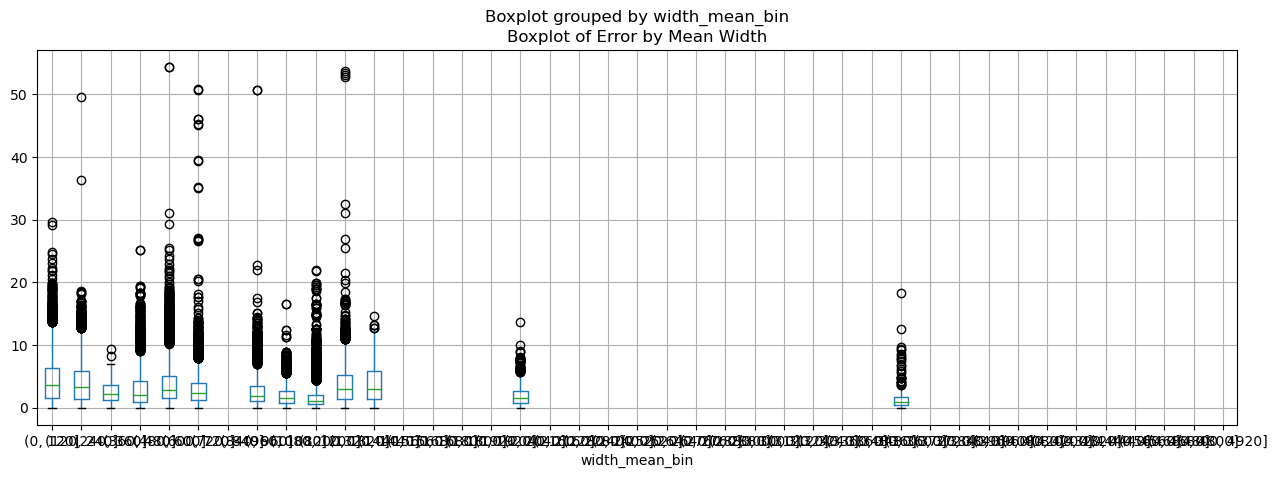

In [45]:
# boxplot of error
fig, ax = plt.subplots(figsize=(15, 5))
insitu_lsat_clean.boxplot('abs_error', by='width_mean_bin', ax=ax,)
# # plot mean and median lines
# ax.plot(insitu_err_agg['rmse'], color='red', linestyle='--', label='mean')
# set x tick labels to mid of bin
# ax.set_xticklabels(width_err_agg['WidthMean'])
# ax.set_title('Boxplot of Error by Average Temperature')
ax.set_title('Boxplot of Error by Mean Width')

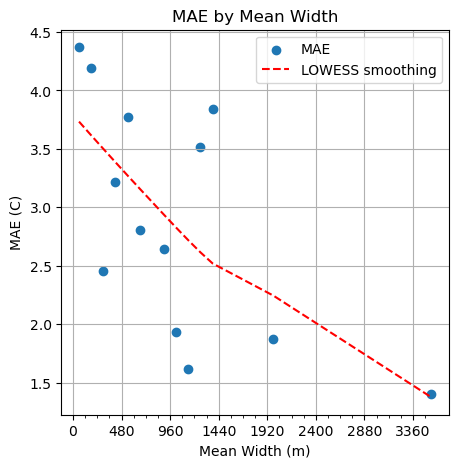

In [46]:
# plot the mean errors
fig, ax = plt.subplots(figsize=(5,5))
# width_err_agg.plot('WidthMean', 'rmse', ax=ax, label='mean', color='black')
# width_err_agg.plot('WidthMean', 'abs_error_mean', ax=ax, label='abs mean', color='red')
# ax.plot(width_err_agg['WidthMean'], width_err_agg['mae'], marker='o')
ax.scatter(width_err_agg['WidthMean'], width_err_agg['mae'], marker='o', label='MAE')
ax.set_ylabel('MAE (C)')
ax.set_xlabel('Mean Width (m)')
ax.set_title('MAE by Mean Width')

# add a lowess smoothing line
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
z = lowess(width_err_agg['mae'], width_err_agg['WidthMean'], frac=1)
ax.plot(z[:, 0], z[:, 1], color='red', linestyle='--', label='LOWESS smoothing')
# add grid
ax.grid()
ax.set_xticks(np.arange(0, 3600, 480))
# set minor ticks
ax.set_xticks(np.arange(0, 3600, 120), minor=True)
ax.legend()


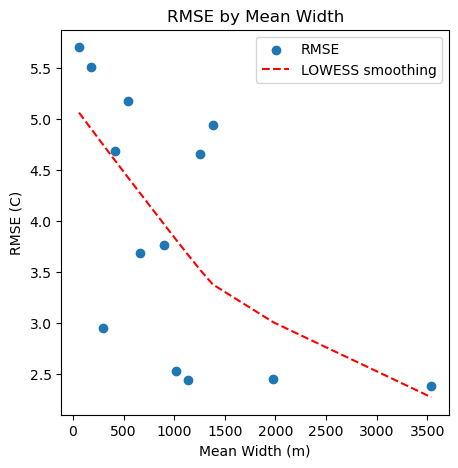

In [47]:
# plot the mean errors
fig, ax = plt.subplots(figsize=(5,5))
# width_err_agg.plot('WidthMean', 'rmse', ax=ax, label='mean', color='black')
# width_err_agg.plot('WidthMean', 'abs_error_mean', ax=ax, label='abs mean', color='red')
# ax.plot(width_err_agg['WidthMean'], width_err_agg['rmse'], marker='o')
ax.scatter(width_err_agg['WidthMean'], width_err_agg['rmse'], marker='o', label='RMSE')
ax.set_ylabel('RMSE (C)')
ax.set_xlabel('Mean Width (m)')
ax.set_title('RMSE by Mean Width')

# add a lowess smoothing line
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
z = lowess(width_err_agg['rmse'], width_err_agg['WidthMean'], frac=1)
ax.plot(z[:, 0], z[:, 1], color='red', linestyle='--', label='LOWESS smoothing')
ax.legend()


LOWESS stands for Locally Weighted Scatterplot Smoothing

In [48]:
# bin insitu_lsat by average temperature
insitu_lsat_clean['width_mean_bin'] = pd.cut(insitu_lsat_clean['WidthMean'], bins=np.arange(0, 5000, 60))
# create a column for width class such that if width < 120 then width_class = 0, else 1
insitu_lsat_clean['width_class'] = insitu_lsat_clean['WidthMean'].apply(lambda x: 'Width < 120m' if x < 120 else 'Width >= 120m')

# calculate mean, min, max, 75, 25, and standard deviation of water temperature
# width_err_agg_class = insitu_lsat_clean.groupby('width_mean_bin').agg({'error': ['mean', 'min', 'max', 'std', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75), lambda x: x.quantile(0.5), lambda x: np.sqrt(np.mean(x**2)), lambda x: np.abs(x).mean()]})
width_err_agg_class = insitu_lsat_clean.groupby('width_class').agg({'error': ['mean', 'min', 'max', 'std', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75), lambda x: x.quantile(0.5), lambda x: np.sqrt(np.mean(x**2)), lambda x: np.abs(x).mean(), lambda x: np.abs(x).median()]})

width_err_agg_class.columns = ['mean', 'min', 'max', 'std', 'q25', 'q75', 'q50', 'rmse', 'abs_error_mean', 'abs_error_med']

width_err_agg_class.reset_index(inplace=True)
# width_err_agg_class['WidthMean'] = width_err_agg_class['width_mean_bin'].apply(lambda x: x.mid)

width_err_agg_class['iqr'] = width_err_agg_class['q75'] - width_err_agg_class['q25']
width_err_agg_class.dropna(inplace=True)


In [49]:
width_err_agg_class

,width_class,mean,min,max,std,q25,q75,q50,rmse,abs_error_mean,abs_error_med,iqr
0,Width < 120m,3.129921,-24.7611,29.5561,4.769152,0.087365,5.98695,2.826745,5.704212,4.370295,3.56075,5.899585
1,Width >= 120m,1.320364,-49.5573,54.3909,3.700588,-0.456250,3.06090,1.189000,3.929057,2.780579,1.99344,3.517150


Text(0.5, 1.0, 'Absolute Error by Width Class')

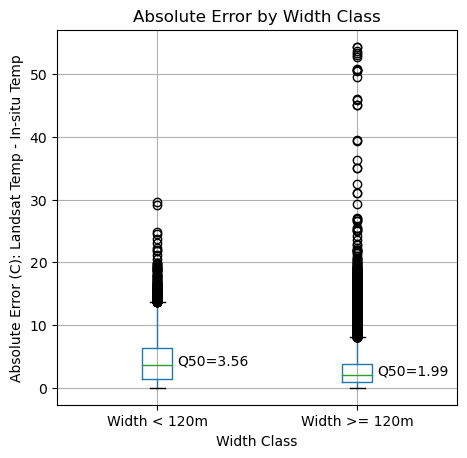

In [50]:
# boxplot of error
# fig, ax = plt.subplots(figsize=(5, 5))
fig, ax = plt.subplots(figsize=(5, 5))
# ax.boxplot(insitu_lsat_clean['abs_error'])
insitu_lsat_clean.boxplot('abs_error', by='width_class', ax=ax,)
# ax.set_title('Boxplot of Error by Width Class')
fig.suptitle(None)
# anotate with abs_error_mean
for i, row in width_err_agg_class.iterrows():
    ax.annotate(f"Q50={row['abs_error_med']:.2f}", (i+1.1, row['abs_error_med']))

ax.set_ylabel('Absolute Error (C): Landsat Temp - In-situ Temp')
ax.set_xlabel('Width Class')
ax.set_title('Absolute Error by Width Class')

In [51]:
np.abs(insitu_lsat_clean['error']).median()

2.103999999999999

The mean absolute error of all the data is approximately 3 degC.

<Axes: title={'center': 'error'}, xlabel='Mission'>

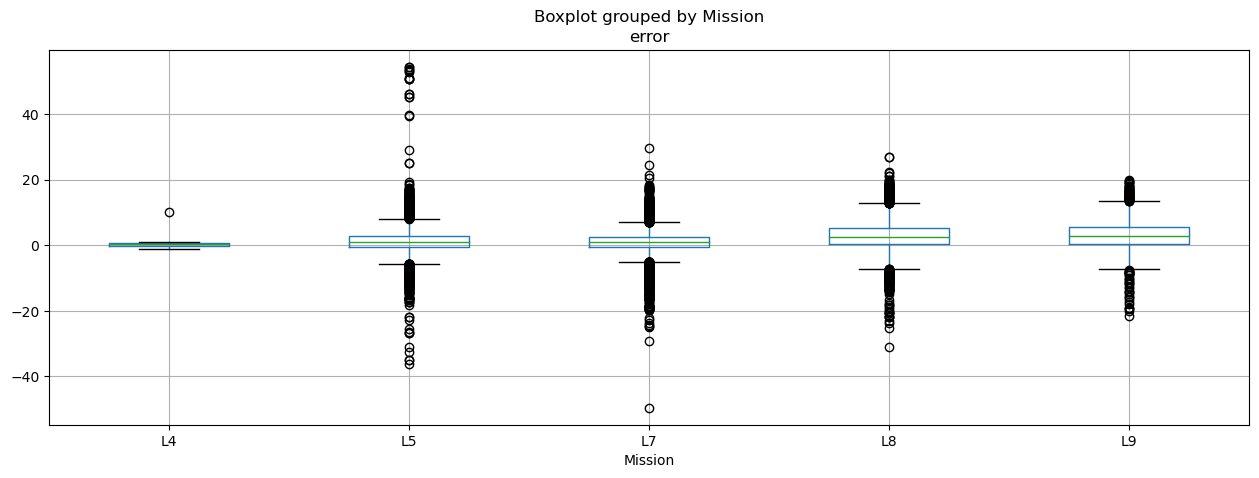

In [52]:
# boxplot of rmse with mission
fig, ax = plt.subplots(figsize=(15, 5))
insitu_lsat_clean.boxplot('error', by='Mission', ax=ax)

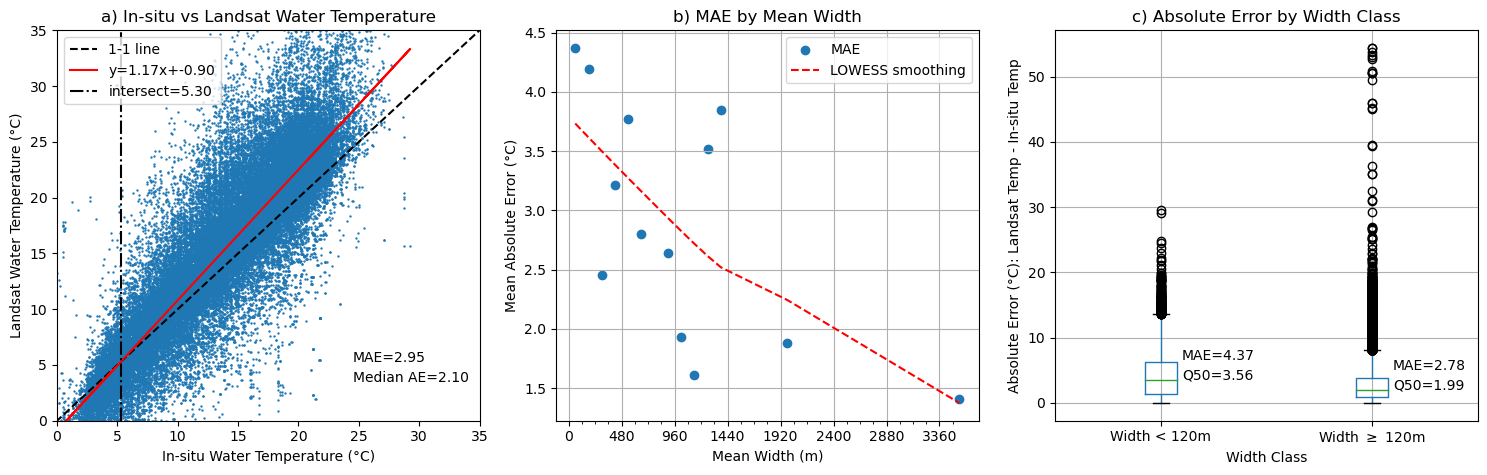

In [55]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5) )

insitu_lsat_clean.plot.scatter(y="WaterTempC", x="avg_temp(C)", ax=ax0, s=0.5)
# insitu_lsat_clean.plot.scatter(
#     y="WaterTempC", x="avg_temp(C)", ax=ax1, s=0.5, c="ClimateClass", cmap="viridis"
# )
# insitu_lsat_clean.plot.scatter(
#     y="WaterTempC", x="avg_temp(C)", ax=ax2, s=0.5, c="WidthMax", cmap="viridis"
# )

# draw 1-1 line
ax0.plot([-5, 40], [-5, 40], color="black", linestyle="--", label="1-1 line")
ax0.plot(
    insitu_lsat_clean["avg_temp(C)"],
    m * insitu_lsat_clean["avg_temp(C)"] + b,
    color="red",
    label=f"y={m:.2f}x+{b:.2f}",
)

# annotate with MAE and RMSE
ax0.annotate(
    f"MAE={insitu_lsat_clean['abs_error'].mean():.2f}",
    xy=(0.70, 0.15),
    xycoords="axes fraction",
)
ax0.annotate(
    f"Median AE={insitu_lsat_clean['abs_error'].median():.2f}",
    xy=(0.70, 0.10),
    xycoords="axes fraction",
)


ax0.axvline(x=intersect, color="black", linestyle="-.", label=f"intersect={intersect:.2f}")

ax0.set_ylabel("Landsat Water Temperature (°C)")
ax0.set_xlabel("In-situ Water Temperature (°C)")
ax0.set_title('a) In-situ vs Landsat Water Temperature')
ax0.set_xlim(0, 35)
ax0.set_ylim(-0, 35)

ax0.legend(loc="upper left")

ax1.scatter(width_err_agg['WidthMean'], width_err_agg['mae'], marker='o', label='MAE')
ax1.set_ylabel('Mean Absolute Error (°C)')
ax1.set_xlabel('Mean Width (m)')
ax1.set_title('b) MAE by Mean Width')

# add a lowess smoothing line
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
z = lowess(width_err_agg['mae'], width_err_agg['WidthMean'], frac=1)
ax1.plot(z[:, 0], z[:, 1], color='red', linestyle='--', label='LOWESS smoothing')# add grid
ax1.grid()
ax1.set_xticks(np.arange(0, 3600, 480))
# set minor ticks
ax1.set_xticks(np.arange(0, 3600, 120), minor=True)
ax1.legend()

insitu_lsat_clean.boxplot('abs_error', by='width_class', ax=ax2,)
# ax.set_title('Boxplot of Error by Width Class')
fig.suptitle(None)
# anotate with abs_error_med and abs_error_mean
for i, row in width_err_agg_class.iterrows():
    ax2.annotate(f"Q50={row['abs_error_med']:.2f}", (i+1.1, row['abs_error_med']))
    ax2.annotate(f"MAE={row['abs_error_mean']:.2f}", (i+1.1, row['abs_error_med']+3))
    

ax2.set_ylabel('Absolute Error (°C): Landsat Temp - In-situ Temp')
ax2.set_xlabel('Width Class')
ax2.set_title('c) Absolute Error by Width Class')
ax2.set_xticklabels(['Width < 120m', 'Width $\geq$ 120m'])

fig.tight_layout()
fig.savefig('insitu_vs_landsat_temp.png', dpi=300);

In [59]:
width_err_agg_class

,width_class,mean,min,max,std,q25,q75,q50,rmse,abs_error_mean,abs_error_med,iqr
0,Width < 120m,3.129921,-24.7611,29.5561,4.769152,0.087365,5.98695,2.826745,5.704212,4.370295,3.56075,5.899585
1,Width >= 120m,1.320364,-49.5573,54.3909,3.700588,-0.456250,3.06090,1.189000,3.929057,2.780579,1.99344,3.517150
